## StarGAN v2 with CelebA dataset

In [32]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import itertools
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random
import math

In [14]:
workers = 2
batch_size = 16
image_size = 256

epochs = 50
lr = 0.0001
beta1, beta2 = 0.5, 0.999
n_critic = 5
lamb_cls, lamb_gp, lamb_rec = 1, 10, 5
n_ep_decay = 25
lr_update_step = 1000
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "./model"

print("Device: ", end="")
print(device)

Device: cuda:0


In [24]:
import os.path

if os.path.isdir('./data'):
    print("Already files exist.\n")
    !du -sh ./data/celeba_hq/train/male
    !ls -l ./data/celeba_hq/train/male | grep ^- | wc -l
    !du -sh ./data/celeba_hq/train/female
    !ls -l ./data/celeba_hq/train/female | grep ^- | wc -l

else:
    !mkdir -p ./data
    !wget -N https://www.dropbox.com/s/f7pvjij2xlpff59/celeba_hq.zip?dl=0 -O ./data/celeba_hq.zip
    !unzip ./data/celeba_hq.zip -d ./data
    !rm ./data/celeba_hq.zip

Already files exist.

814M	./data/celeba_hq/train/male
10057
1.7G	./data/celeba_hq/train/female
17943


In [29]:
class CelebA(torch.utils.data.Dataset):
    def __init__(self, transform=None, mode='train'):
        male_path = './data/celeba_hq/' + mode + '/male/*.jpg'
        female_path = './data/celeba_hq/' + mode + '/female/*.jpg'
        self.paths = glob(male_path) + glob(female_path)
        random.shuffle(self.paths)
        
        self.transform = transform
        self.length = len(self.paths)
        print('Total %d images' % self.length)
        
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if self.transform:
            img = self.transform(img)
        
        return img

    def __len__(self):
        return self.length

# Restore images to suitable images of opencv style
def ImgForPlot(img):
    img = np.einsum('ijk->jki', img)
    img = (127.5*(img+1)).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [30]:
transform=transforms.Compose([transforms.ToTensor(),
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

dataset = CelebA(transform=transform, mode='train')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

Total 28000 images


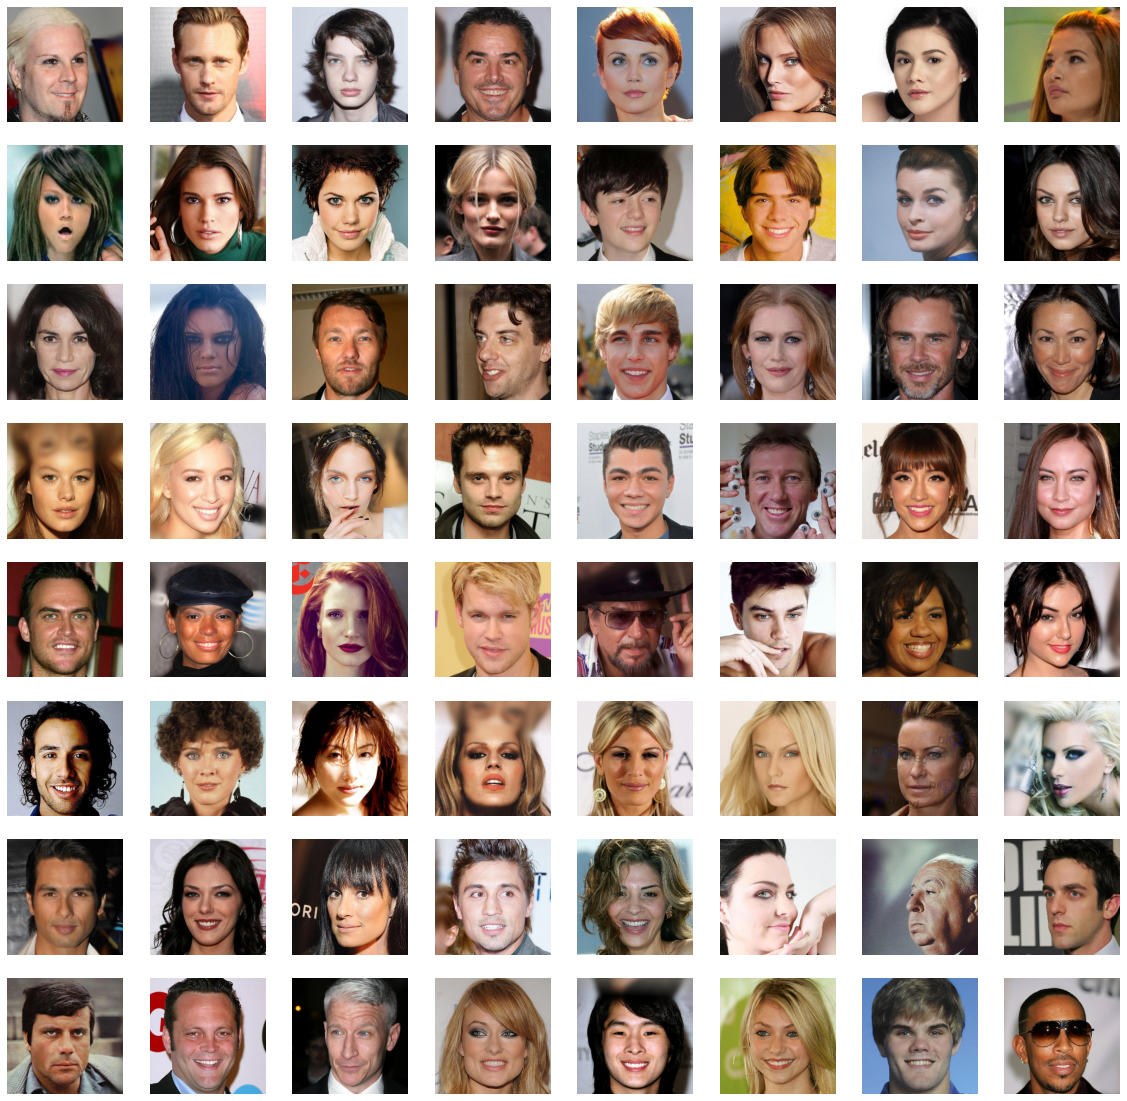

In [31]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
    img = dataset[k]
    ax = fig.add_subplot(8, 8, k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    
plt.show()

# Networks  
## Weight initialize

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Residual Block and AdaIN

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, downsample=False):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        
        self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
        self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        self.lrelu = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        
        if learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)
    
    def forward(self, x):
        res = self.norm1(x)
        res = self.lrelu(res)
        res = self.conv1(res)
        
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            res = F.avg_pool2d(res, 2)
            x = F.avg_pool2d(x, 2)
                       
        res = self.norm2(res)
        res = self.lrelu(res)
        res = self.conv2(res)
        
        return (x + res) / math.sqrt(2)
    

class AdaIN(nn.Module):
    def __init__(self, x_dim, s_dim=64):
        super().__init__()
        self.norm = nn.InstanceNorm2d(x_dim, affine=False)
        self.fc = nn.Linear(s_dim, x_dim*2)
    
    def forward(self, x, s):
        s = self.fc(s)
        s = s.view(s.size(0), s.size(1), 1, 1)
        gamma, beta = torch.chunk(s, chunk=2, dim=1)
        return (1+gamma) * self.norm(x) + beta
    

class AdainResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, s_dim=64, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out
        
        self.adain1 = AdaIN(dim_in, s_dim)
        self.adain2 = AdaIN(dim_out, s_dim)
        self.lrelu = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        
        if learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)
        
    def forward(self, x, s):
        res = self.adain1(x, s)
        res = self.lrelu(res)
        if self.upsample:
            res = F.interpolate(res, scale_factor=2, mode='nearest')
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.learned_sc:
            x = self.conv1x1(x)
        res = self.conv1(res)
        res = self.adain2(res, s)
        res = self.lrelu(res)
        res = self.conv2(res)
        
        return (res + x) / math.sqrt(2)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_features=64):
        super().__init__()
        
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.conv1 = nn.Conv2d(3, n_features, 3, 1, 1)
        self.conv2 = nn.Conv2d(n_features, 3, 1, 1, 0)
        self.lrelu = nn.LeakyReLU(0.2)
        self.norm = nn.InstanceNorm2d(n_features, affine=True)
        
        dim_in = n_features
        for i in range(4):
            dim_out = min(dim_in*2, 512)
            self.encode.append(ResBlock(dim_in, dim_out, downsample=True))
            self.decode.insert(0, AdainResBlock(dim_out, dim_in, upsample=True))
            dim_in = dim_out
        
        for i in range(2):
            self.encode.append(ResBlock(512, 512))
            self.decode.insert(0, AdainResBlock(512, 512))
        

    def forward(self, x, s):
        x = self.conv1(x)
        for block in self.encode:
            x = block(x)
        for block in self.decode:
            x = block(x, s)
        x = self.norm(x)
        x = self.lrelu(x)
        x = self.conv2(x)
        
        return x

## Mapping Network

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim=16, s_dim=64, n_domain=2):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(z_dim, 512)
            nn.ReLU()
            nn.Linear(512, 512)
            nn.ReLU()
            nn.Linear(512, 512)
            nn.ReLU()
            nn.Linear(512, 512)
            nn.ReLU()
        )
        self.unshared = nn.ModuleList()
        
        
    def forward(self, x):
        return x        

## Style Encoder

In [ ]:
class StyleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
    def forward(self, x)
        return x

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        
    def forward(self, x)
        return x